In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [64]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch 
from torch import nn 
import torchvision 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

train_data = torchvision.datasets.FashionMNIST(root='data',
                                  train=True,
                                  download=True,
                                  transform=torchvision.transforms.ToTensor(),
                                  target_transform=None)

test_data = torchvision.datasets.FashionMNIST(root='data',
                                  train=False,
                                  download=True,
                                  transform=torchvision.transforms.ToTensor(),
                                  target_transform=None)

In [65]:
train_dataloader = DataLoader(dataset=train_data,batch_size=128,shuffle=False)
test_dataloader = DataLoader(dataset=test_data,batch_size=128,shuffle=False)
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of the Train DataLoader: {len(train_dataloader)} Batches Of 128")
print(f"Length of the Test DataLoader: {len(test_dataloader)} Batches Of 128")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x000002130C707A10>, <torch.utils.data.dataloader.DataLoader object at 0x00000212BED12690>)
Length of the Train DataLoader: 469 Batches Of 128
Length of the Test DataLoader: 79 Batches Of 128


In [66]:
image, label = train_data[0]
print(len(train_data.classes))
class_name = train_data.classes
class_name

10


['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [67]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [68]:
class FashionMNISTModel(nn.Module):
    def __init__(self, input_shape: int,hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
         nn.Conv2d(in_channels = input_shape ,
                   out_channels = hidden_units,
                   kernel_size=3,
                   stride=1,
                   padding=1),
         nn.ReLU(),
         nn.Conv2d(in_channels =hidden_units,
                 out_channels = hidden_units,
                 kernel_size=3,
                 stride= 1,
                 padding=1),
         nn.ReLU(),
         nn.MaxPool2d(kernel_size=2))
        self.conv_block_2 = nn.Sequential(
         nn.Conv2d(in_channels = hidden_units ,
                   out_channels = hidden_units,
                   kernel_size=3,
                   stride=1,
                   padding=1),
         nn.ReLU(),
         nn.Conv2d(in_channels =hidden_units,
                 out_channels = hidden_units,
                 kernel_size=3,
                 stride= 1,
                 padding=1),
         nn.ReLU(),
         nn.MaxPool2d(kernel_size=2))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape))
    def forward(self,x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)

        return x

In [69]:
from torchvision import models

class FashionMNISTPretrained(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        num_ftrs = self.resnet18.fc.in_features
        self.resnet18.conv1 = nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1)
        self.resnet18.fc = nn.Linear(num_ftrs, output_shape)

    def forward(self, x):
        x = self.resnet18(x)
        return x

In [70]:
model = FashionMNISTModel(image.shape[0],10,len(class_name))
model.to(device)

FashionMNISTModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [71]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [72]:
from tqdm.auto import tqdm

def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device, calculate_feat_imp=False):
    model.train()
    train_loss, train_acc = 0, 0
    if calculate_feat_imp:
        feat_imp = torch.zeros((1, 28, 28), device=device)

    # Use tqdm for progress tracking
    loop = tqdm(enumerate(data_loader), total=len(data_loader), leave=False)
    for batch, (X, y) in loop:
        X, y = X.to(device), y.to(device)

        if calculate_feat_imp and X.requires_grad == False:
            X.requires_grad = True

        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        if calculate_feat_imp:
            with torch.no_grad():
                gradients = torch.autograd.grad(outputs=y_pred, inputs=X, grad_outputs=torch.ones_like(y_pred), only_inputs=True, retain_graph=True)[0]
                feat_imp += torch.abs(gradients).mean(dim=0)

        train_loss += loss.item()
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar
        loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        loop.set_postfix(loss=loss.item(), acc=accuracy_fn(y, y_pred.argmax(dim=1)))

    if calculate_feat_imp:
        feat_imp /= len(data_loader)
        feat_imp = feat_imp.cpu().numpy()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"\nTrain Loss: {train_loss:.5f} | Train Acc: {train_acc:.2f}%")

    return feat_imp if calculate_feat_imp else None
epochs=30
# Training loop with progress tracking and feature importance calculation
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    if epoch == epochs - 1:  # Calculate feature importance in the last epoch
        feat_imp = train_step(model, train_dataloader, loss_fn, optimizer, accuracy_fn, device, calculate_feat_imp=True)
    else:
        train_step(model, train_dataloader, loss_fn, optimizer, accuracy_fn, device)


Epoch 1/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 1.31918 | Train Acc: 51.15%
Epoch 2/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.49805 | Train Acc: 81.61%
Epoch 3/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.41077 | Train Acc: 85.12%
Epoch 4/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.37465 | Train Acc: 86.39%
Epoch 5/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.35156 | Train Acc: 87.33%
Epoch 6/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.33466 | Train Acc: 87.97%
Epoch 7/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.32144 | Train Acc: 88.43%
Epoch 8/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.31069 | Train Acc: 88.80%
Epoch 9/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.30130 | Train Acc: 89.17%
Epoch 10/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.29319 | Train Acc: 89.41%
Epoch 11/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.28590 | Train Acc: 89.66%
Epoch 12/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.27970 | Train Acc: 89.82%
Epoch 13/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.27477 | Train Acc: 90.02%
Epoch 14/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.26978 | Train Acc: 90.18%
Epoch 15/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.26590 | Train Acc: 90.32%
Epoch 16/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.26192 | Train Acc: 90.50%
Epoch 17/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.25813 | Train Acc: 90.65%
Epoch 18/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.25501 | Train Acc: 90.77%
Epoch 19/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.25173 | Train Acc: 90.88%
Epoch 20/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.24877 | Train Acc: 90.93%
Epoch 21/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.24634 | Train Acc: 91.03%
Epoch 22/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.24330 | Train Acc: 91.15%
Epoch 23/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.24093 | Train Acc: 91.14%
Epoch 24/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.23877 | Train Acc: 91.31%
Epoch 25/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.23585 | Train Acc: 91.35%
Epoch 26/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.23419 | Train Acc: 91.44%
Epoch 27/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.23178 | Train Acc: 91.53%
Epoch 28/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.22943 | Train Acc: 91.62%
Epoch 29/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.22753 | Train Acc: 91.65%
Epoch 30/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.22553 | Train Acc: 91.77%


In [73]:
# Fetch a single batch from the DataLoader
images, labels = next(iter(train_dataloader))

In [74]:
# Select the first image and label from the batch
image_to_visualize = images[0].to('cpu')
label = labels[0].item()

In [75]:
# image_to_visualize.shape
feat_imp.shape

(1, 28, 28)

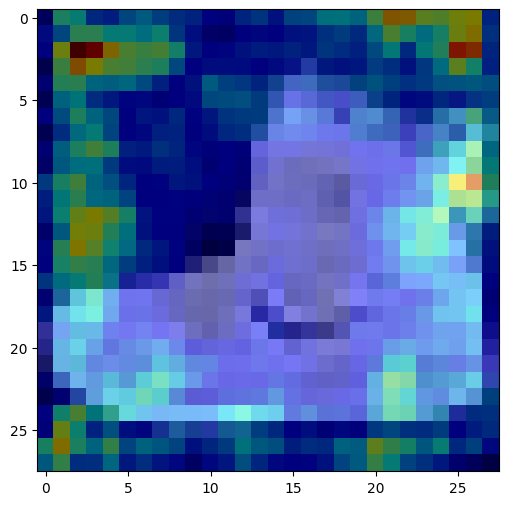

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Convert them to numpy arrays and remove the first dimension
image1 = image_to_visualize.squeeze().numpy()
image2 = feat_imp.squeeze()

plt.figure(figsize=(6, 6))

# Plot the first image
plt.imshow(image1, cmap='gray')

# Overlay the second image
# Alpha controls the transparency: 0 is fully transparent, 1 is fully opaque
plt.imshow(image2, cmap='jet', alpha=0.5)

# plt.show()

In [77]:
image1

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

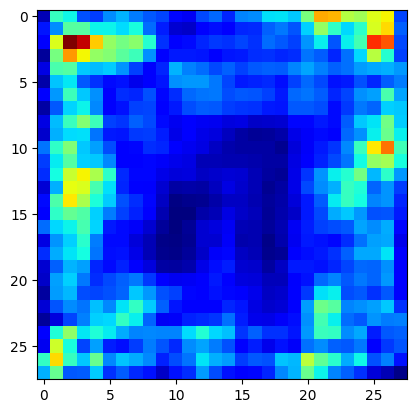

In [78]:
plt.imshow(image2, cmap='jet')

In [79]:
import numpy as np

# Assuming feat_imp is a numpy array with shape (1, 28, 28) and already calculated
feat_imp_flat = feat_imp.flatten()  # Flatten the feature importance map

# Determine the threshold for the top 10%
k = int(0.9 * len(feat_imp_flat))  # Index for the 90th percentile; we keep top 10%, hence 100% - 90%
threshold = np.sort(feat_imp_flat)[k]

# Create a mask for top 10% of features
mask = feat_imp > threshold  # This will be True for top 10%, False otherwise
# mask = mask.astype(float)

In [80]:
from torchvision.transforms import Lambda

def apply_mask(img):
    return img * mask

masked_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    Lambda(apply_mask)
])

In [81]:
train_data = torchvision.datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=masked_transform,
    target_transform=None
)

test_data = torchvision.datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=masked_transform,
    target_transform=None
)
train_dataloader = DataLoader(dataset=train_data,batch_size=128,shuffle=False)
test_dataloader = DataLoader(dataset=test_data,batch_size=128,shuffle=False)

In [82]:
images, labels = next(iter(train_dataloader))
# Select the first image and label from the batch
image_to_visualize = images[0].to('cpu')

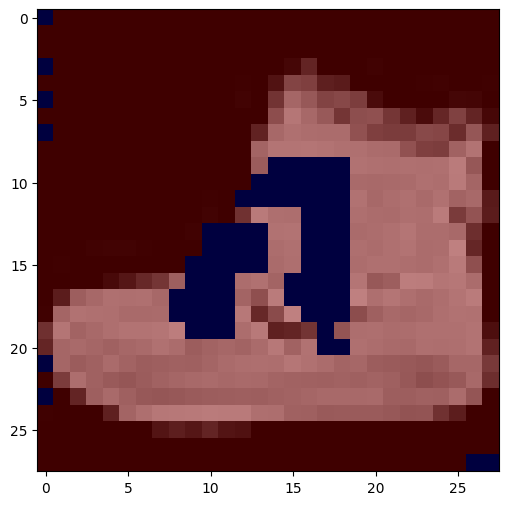

In [83]:
images, labels = next(iter(train_dataloader))
# Select the first image and label from the batch
image_to_visualize = images[0].to('cpu')
label = labels[0].item()
# Convert them to numpy arrays and remove the first dimension
image1 = image_to_visualize.squeeze().numpy()
image2 = mask.squeeze()

plt.figure(figsize=(6, 6))

# Plot the first image
plt.imshow(image1, cmap='gray')

# Overlay the second image
# Alpha controls the transparency: 0 is fully transparent, 1 is fully opaque
plt.imshow(image2, cmap='jet', alpha=0.5)

# plt.show()

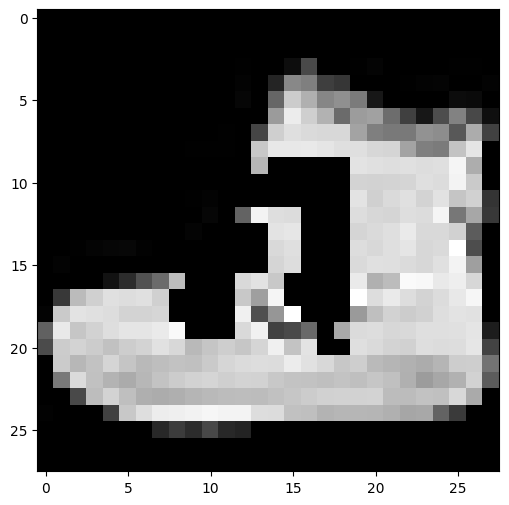

In [84]:
images, labels = next(iter(train_dataloader))
# Select the first image and label from the batch
image_to_visualize = images[0].to('cpu')
label = labels[0].item()
import matplotlib.pyplot as plt
import numpy as np

# Convert them to numpy arrays and remove the first dimension
image1 = image_to_visualize.squeeze().numpy()
plt.figure(figsize=(6, 6))

# Plot the first image
plt.imshow(image1, cmap='gray')

In [85]:
from tqdm.auto import tqdm

def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device, calculate_feat_imp=False):
    model.train()
    train_loss, train_acc = 0, 0
    if calculate_feat_imp:
        feat_imp = torch.zeros((1, 28, 28), device=device)

    # Use tqdm for progress tracking
    loop = tqdm(enumerate(data_loader), total=len(data_loader), leave=False)
    for batch, (X, y) in loop:
        X, y = X.to(device), y.to(device)

        if calculate_feat_imp and X.requires_grad == False:
            X.requires_grad = True

        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        if calculate_feat_imp:
            # Perform feature importance calculation before backward pass
            with torch.no_grad():
                gradients = torch.autograd.grad(outputs=y_pred, inputs=X, grad_outputs=torch.ones_like(y_pred), only_inputs=True, retain_graph=True)[0]
                feat_imp += torch.abs(gradients).mean(dim=0)

        train_loss += loss.item()
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar
        loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        loop.set_postfix(loss=loss.item(), acc=accuracy_fn(y, y_pred.argmax(dim=1)))

    if calculate_feat_imp:
        feat_imp /= len(data_loader)
        feat_imp = feat_imp.cpu().numpy()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"\nTrain Loss: {train_loss:.5f} | Train Acc: {train_acc:.2f}%")

    return feat_imp if calculate_feat_imp else None
epochs=30
# Training loop with progress tracking and feature importance calculation
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    if epoch == epochs - 1:  # Calculate feature importance in the last epoch
        feat_imp = train_step(model, train_dataloader, loss_fn, optimizer, accuracy_fn, device, calculate_feat_imp=False)
    else:
        train_step(model, train_dataloader, loss_fn, optimizer, accuracy_fn, device)


Epoch 1/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.34455 | Train Acc: 87.90%
Epoch 2/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.27893 | Train Acc: 89.86%
Epoch 3/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.26740 | Train Acc: 90.29%
Epoch 4/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.26030 | Train Acc: 90.49%
Epoch 5/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.25538 | Train Acc: 90.71%
Epoch 6/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.25129 | Train Acc: 90.88%
Epoch 7/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.24687 | Train Acc: 91.01%
Epoch 8/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.24377 | Train Acc: 91.13%
Epoch 9/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.24069 | Train Acc: 91.22%
Epoch 10/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.23780 | Train Acc: 91.38%
Epoch 11/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.23554 | Train Acc: 91.46%
Epoch 12/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.23335 | Train Acc: 91.56%
Epoch 13/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.23142 | Train Acc: 91.63%
Epoch 14/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.22964 | Train Acc: 91.67%
Epoch 15/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.22779 | Train Acc: 91.77%
Epoch 16/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.22633 | Train Acc: 91.82%
Epoch 17/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.22479 | Train Acc: 91.87%
Epoch 18/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.22364 | Train Acc: 91.83%
Epoch 19/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.22203 | Train Acc: 91.95%
Epoch 20/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.22090 | Train Acc: 92.01%
Epoch 21/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.21911 | Train Acc: 92.06%
Epoch 22/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.21776 | Train Acc: 92.06%
Epoch 23/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.21697 | Train Acc: 92.10%
Epoch 24/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.21579 | Train Acc: 92.14%
Epoch 25/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.21461 | Train Acc: 92.17%
Epoch 26/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.21389 | Train Acc: 92.15%
Epoch 27/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.21208 | Train Acc: 92.29%
Epoch 28/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.21134 | Train Acc: 92.32%
Epoch 29/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.21050 | Train Acc: 92.31%
Epoch 30/30


  0%|          | 0/469 [00:00<?, ?it/s]


Train Loss: 0.21020 | Train Acc: 92.28%
